In [9]:
import Pkg; Pkg.activate("../.")

using Revise
using DeconvMultiStep

using FITSIO
using Plots
default(titlefontsize = 10) 

using Random
Random.seed!(1234)

  Activating project at `~/Desktop/En cours !/Simon/DeconvMultiStep/simu/DeconvMultiStep`


TaskLocalRNG()

## Make UV planes

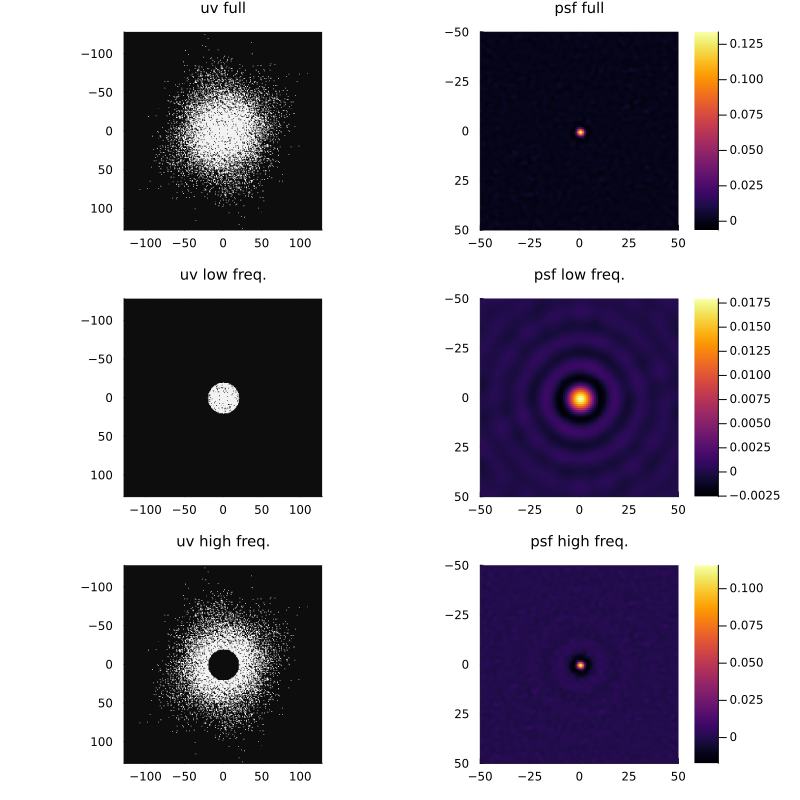

In [10]:
# number of antennas
n_ants = 128

# baseline threshold (in pixels)
ℓ = 20.0

# sky file

# sky = Float64.(dropdims(read(FITS("m31_sky.fits")[1]); dims=3))
sky = Float64.(read(FITS("lena.fits")[1]))
sky /= maximum(sky)
n_pix,  = size(sky)

# make all bases

bases = make_bases(n_ants, n_pix)

# split bases and make psf's

psf, uv = make_psf(bases, n_pix,  ℓ) 

p1 = imshow_uv(uv.full, title="uv full")
p2 = imshow_psf(psf.full, zoom = 50, title="psf full")

p3 = imshow_uv(uv.low, title="uv low freq.")
p4 = imshow_psf(psf.low, zoom=50,  title="psf low freq.")

p5 = imshow_uv(uv.high, title="uv high freq.")
p6 = imshow_psf(psf.high, zoom=50, title="psf high freq.")

p7 = plot(p1, p2, p3, p4, p5, p6, layout=(3,2), size = (800, 800))

## Make dirty images

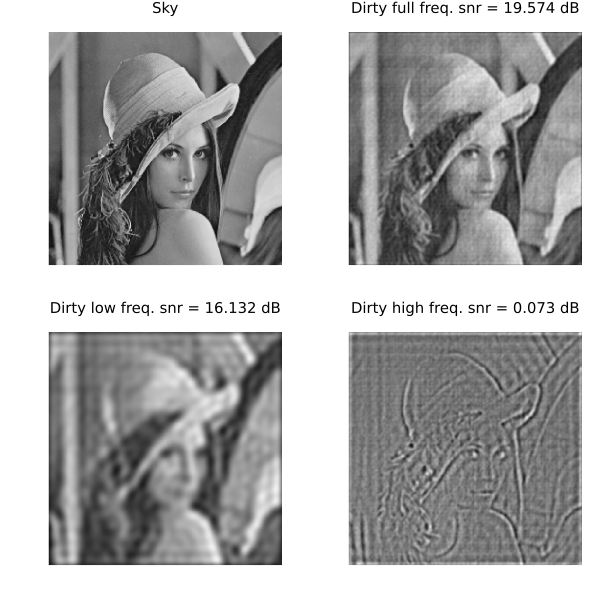

In [11]:
dirty = make_dirty(psf, sky, 0.0)

p1 = imshow(sky, title = "Sky")
p2 = imshow(dirty.full, title = "Dirty full freq. snr = $(snr(sky, dirty.full)) dB")
p3 = imshow(dirty.low, title = "Dirty low freq. snr = $(snr(sky, dirty.low)) dB")
p4 = imshow(dirty.high, title = "Dirty high freq. snr = $(snr(sky, dirty.high)) dB")

plot(p1, p2, p3, p4, layout = (2,2), size = (600, 600))

## Deconv with all visibilitie

Computing... 100%|███████████████████████████████████████| Time: 0:00:07


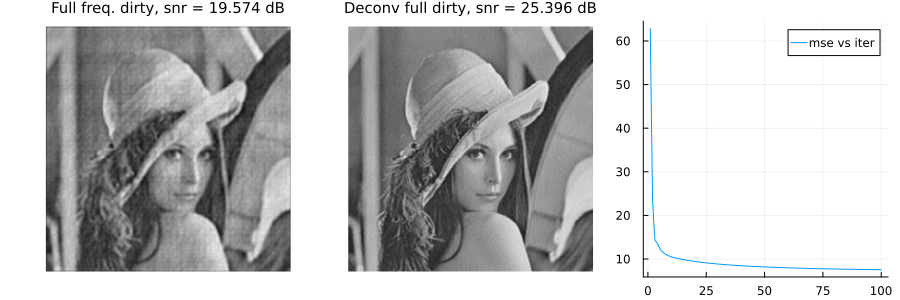

In [12]:
η = compute_step(psf.full)
i_full, mse = fista(psf.full, dirty.full, 1e-5, 100, η; sky=sky)

p1 = imshow(dirty.full, title="Full freq. dirty, snr = $(snr(sky, dirty.full)) dB")
p2 = imshow(i_full, title = "Deconv full dirty, snr = $(snr(sky, i_full)) dB")
p3 = plot(mse, label = "mse vs iter")
plot(p1, p2, p3, layout=(1,3), size = (900, 300))

## Deconv with low frequencies

Computing... 100%|███████████████████████████████████████| Time: 0:00:07


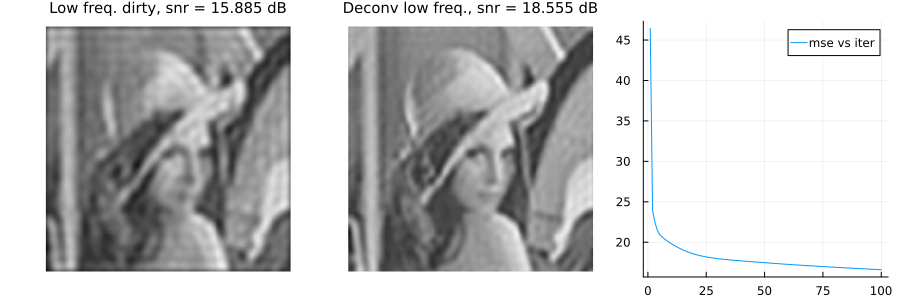

In [7]:
η = compute_step(psf.low)
i_low, mse = fista(psf.low, dirty.low, 1e-4, 100, η; sky=sky)
    
p1 = imshow(dirty.low, title="Low freq. dirty, snr = $(snr(sky, dirty.low)) dB")
p2 = imshow(i_low, title = "Deconv low freq., snr = $(snr(sky, i_low)) dB")
p3 = plot(mse, label = "mse vs iter")
plot(p1, p2, p3, layout=(1,3), size = (900, 300))

## Add high frequencies

Computing... 100%|███████████████████████████████████████| Time: 0:00:20


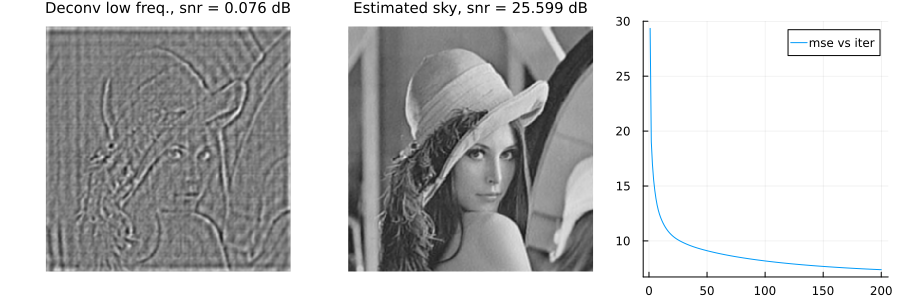

In [8]:
G = sqrt(sum(uv.high)/sum(uv.low))*low_pass(ℓ, n_pix)

η = compute_step(psf.high; G=G)
i_multistep, mse = fista(psf.high, dirty.high, 1e-4, 200, η; G=G, i₀ = i_low, sky=sky)

p1 = imshow(dirty.high, title="Deconv low freq., snr = $(snr(sky, dirty.high)) dB")
p2 = imshow(i_multistep, title = "Estimated sky, snr = $(snr(sky, i_multistep)) dB")
p3 = plot(mse, label = "mse vs iter")
plot(p1, p2, p3, layout=(1,3), size = (900, 300))